
## **Introduction**

I'll be training a Convolutional Neural Networks that will try to predict the steering angle of the car using the video frames extracted from a video recording made while Herbie was using the Lane Keep Assist System (LKAS) written exclusively using OpenCV.

Due to the limited resources on my computer, I'll be harnessing the computing power offered by Google Collab to train my ML model.

**Mount Drive & Assign Output Directory For Trained Model**



In [4]:
from google.colab import drive
drive.mount('/content/drive')

output_directory = '/content/drive/My Drive/Colab Notebooks/Data/Herbie/Saved Models/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**This method will notify me via email when training has been completed**

In [2]:
import smtplib, ssl
from email.message import EmailMessage

def send_email(message: str):
    """
    Send message to indicated email address once training has been completed.
    @ param message: email message
    """
    with open('/content/drive/My Drive/Colab Notebooks/pw.txt') as f:
        data = f.readlines()

    user_name = "maldonadojsm@gmail.com"
    pw = data[0]

    sender_email = user_name
    receiver_email = "maldonadojsm@gmail.com"

    email = EmailMessage()
    email.set_content(message)
    email['Subject'] = "Google Colab"
    email['From'] = sender_email
    email['To'] = receiver_email
    
    context = ssl.create_default_context()

    try:

        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.ehlo()
        server.starttls(context=context)
        server.ehlo()
        server.login(user_name, pw)
        server.send_message(email)

    except Exception as e:
        print(e)

    finally:
        server.quit()


## **Loading Libraries & Packages**

**I'll be using most notably TensorFlow (2.4.0) and Keras (2.4.0) to build and train a Convolutional Nueral Network** 

In [2]:
# Utilities
import os
import random
import fnmatch
import datetime
import pickle

# Image Pre-Processing
import numpy as np
import pandas as pd
import cv2
from imgaug import augmenters
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as plt_img

# Deep Learning
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Confirming TensorFlow & Keras Versions
print( f'tf.__version__: {tf.__version__}')
print( f'keras.__version__: {keras.__version__}')


tf.__version__: 2.4.0
keras.__version__: 2.4.0


## **Generating Training Data**

As described in the introduction, the training data that will be used for this model has been extracted from a video recording made while Herbie was using the LKAS system written in OpenCV. 

**Video:**

https://youtu.be/A-7Yxy5H2lw

Given that a CNN requires images as training data, I'll split the video recording into video frames (.png images) with each frame corresponding to a training instance (see gen_traning_data.py). 

**Generating Labels**

The label (steering angle) of each training instance has been determined using the **LaneKeepAssistSystem Class** found in lane_navigation.py. The recorded video (.avi) has been fed frame by frame into **drive_within_lanes**, with it returning a prediction for the steering angle for said frame (stored in attribute **current_steering_angle**)

**File Naming Structure**

More importantly, the following filename structure has been used to dinstinguish each frame and corresponding label:

```console
[video_file_name]_[frame_number]_[label].png
```

**Example:**

```console
videofoo_000_056.png
```

**Important Observations:**

*   Turning angles range from 0 to 180 degrees.
*   Label values greater than 90 degrees indicate that Herbie is turning **right**
*   Values less than 90 degrees indicate that Herbie is turning **left**
* Values equaling 90 degrees indicate that Herbie is **driving straight**

In this case, Herbie was turning left (056) and it corresponds to frame 000 (first frame of video) corresponding to video named videofoo.

## **Loading Training Data**

I've stored the .png images generated by **gen_training_data.py** in my Google Drive. Generated images have been migrated from **"~/Herbie/ml_models/lane_keep_assist_system/images"**

**Load, Parse & Store Training Labels (Steering Angles)**

In [8]:
training_data_filepath = "/content/drive/My Drive/Colab Notebooks/Data/Herbie/Deep Learning LKAS"

img_list = os.listdir(training_data_filepath)
# X = .png file paths
X = []
y = []

for image in img_list:
    if fnmatch.fnmatch(image, "*.png"):
        X.append(os.path.join(training_data_filepath, image))
        # Index -7 to -4 (non inclusive) correspond to label, with -1 to -4 corresponding to ".png"
        steering_angle = int(image[-7:-4])
        y.append(steering_angle)



**Veryfying Extractions**

Img Path: /content/drive/My Drive/Colab Notebooks/Data/Herbie/Deep Learning LKAS/car_video210118_150339.avi_430_081.png
Label: 81


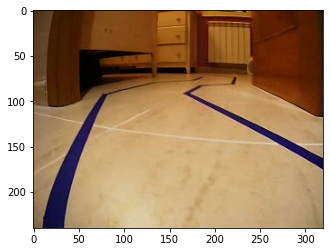

In [6]:
def show_image_info(index):

    plt.imshow(Image.open(X[index]))
    print("Img Path: %s" % X[index])
    print("Label: %s" % y[index])


show_image_info(30)

**Store Images & Labels in Pandas Dataframe**

In [7]:
df = pd.DataFrame()
df['Img'] = X
df['Label'] = y

**Brief EDA**

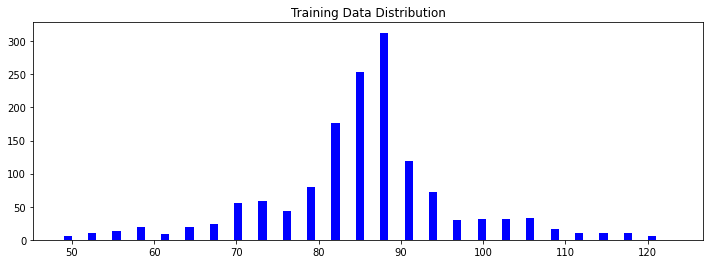

In [8]:
%matplotlib inline

np.set_printoptions(formatter={'float_kind': lambda x: "%.4f" % x})
bins = 25

def gen_histogram(data, title):
    fig, axes = plt.subplots(1, 1, figsize=(12, 4))
    axes.hist(data, bins=bins, width=1, color='blue')
    axes.set_title(title)

gen_histogram(df['Label'], "Training Data Distribution")

**Observations:**

As, expected most of labels correspond to steering angles smaller than 90 degrees. This makes sense given that the car was turning left most of the time in the video.

## **Splitting Training & Validation Data**

X = .png file_paths

y = steering_angle





In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print("Training: %d\nValidation: %d\nTest: %d" % (len(X_train), len(X_val), len(X_test)))



Training: 1017
Validation: 218
Test: 218


**Checking Distributions**

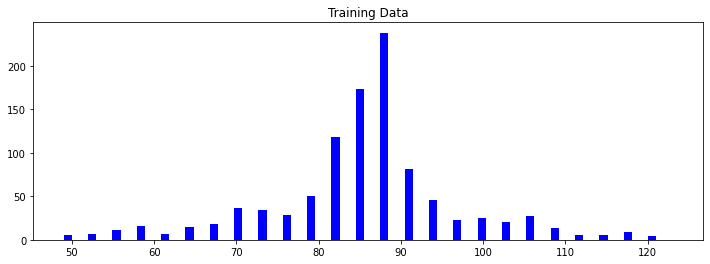

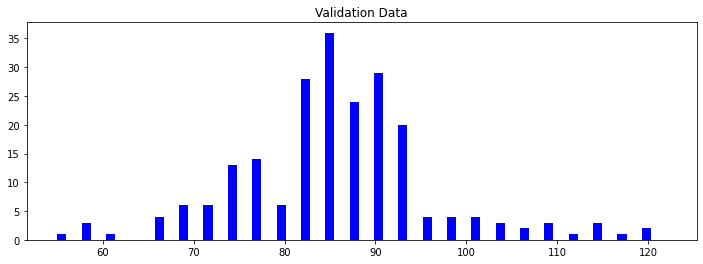

In [11]:
gen_histogram(y_train, "Training Data")
gen_histogram(y_val, "Validation Data")


**Obersverations:**

The distribution of the validation and training data is uneven. I'll compensate this by generating new training data off of the original data via Image Augmentation.

## **Image Augmentation**

In [15]:
class ImageTransformer:
    """
    Applies several forms of image augmentations to source image
    """
    def read_img(self, img_path):
        """
        Read Image
        """
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return img
        
    def apply_zoom(self, img):
        """
        Apply a 30% zoom on image
        """
        zoomed_img = augmenters.Affine(scale=(1, 1.3))
        img = zoomed_img.augment_image(img)

        return img 

    def apply_pan(self, img):
        """
        Apply a L/R/U/D pan to image
        """
        panned_img = augmenters.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = panned_img.augment_image(img)
        
        return img
        
    def apply_brightness(self, img):
        """
        Increase brightness by 30% in image
        """
        bright_img = augmenters.Multiply((0.7, 1.3))
        img = bright_img.augment_image(img)

        return img
        
    def apply_blur(self, img):
        """
        Apply a random degree of blur (determined by range of kernel) to image
        """
        kernel = random.randint(1,5)
        img = cv2.blur(img, (kernel, kernel))

        return img
        
    def apply_flip(self, img, steering_angle):
        """
        Apply a random flip to image
        """
        will_flip = random.randint(0, 1)
        if will_flip == 1:
            img = cv2.flip(img, 1)
            # Difference is opposite angle
            steering_angle = 180 - steering_angle

        return img, steering_angle

    def randomly_augment_img(self,img, steering_angle):
        """
        Randomly applies one of several forms of image augmentation to image
        """

        if np.random.rand() < 0.5:
            img = self.apply_pan(img)
        if np.random.rand() < 0.5:
            img = self.apply_zoom(img)
        if np.random.rand() < 0.5:
            img = self.apply_blur(img)
        if np.random.rand() < 0.5:
            img = self.apply_brightness(img)

        img, flipped_steering_angle  = self.apply_flip(img, steering_angle)

        return img, flipped_steering_angle
    

**Test Some Image Transformations**

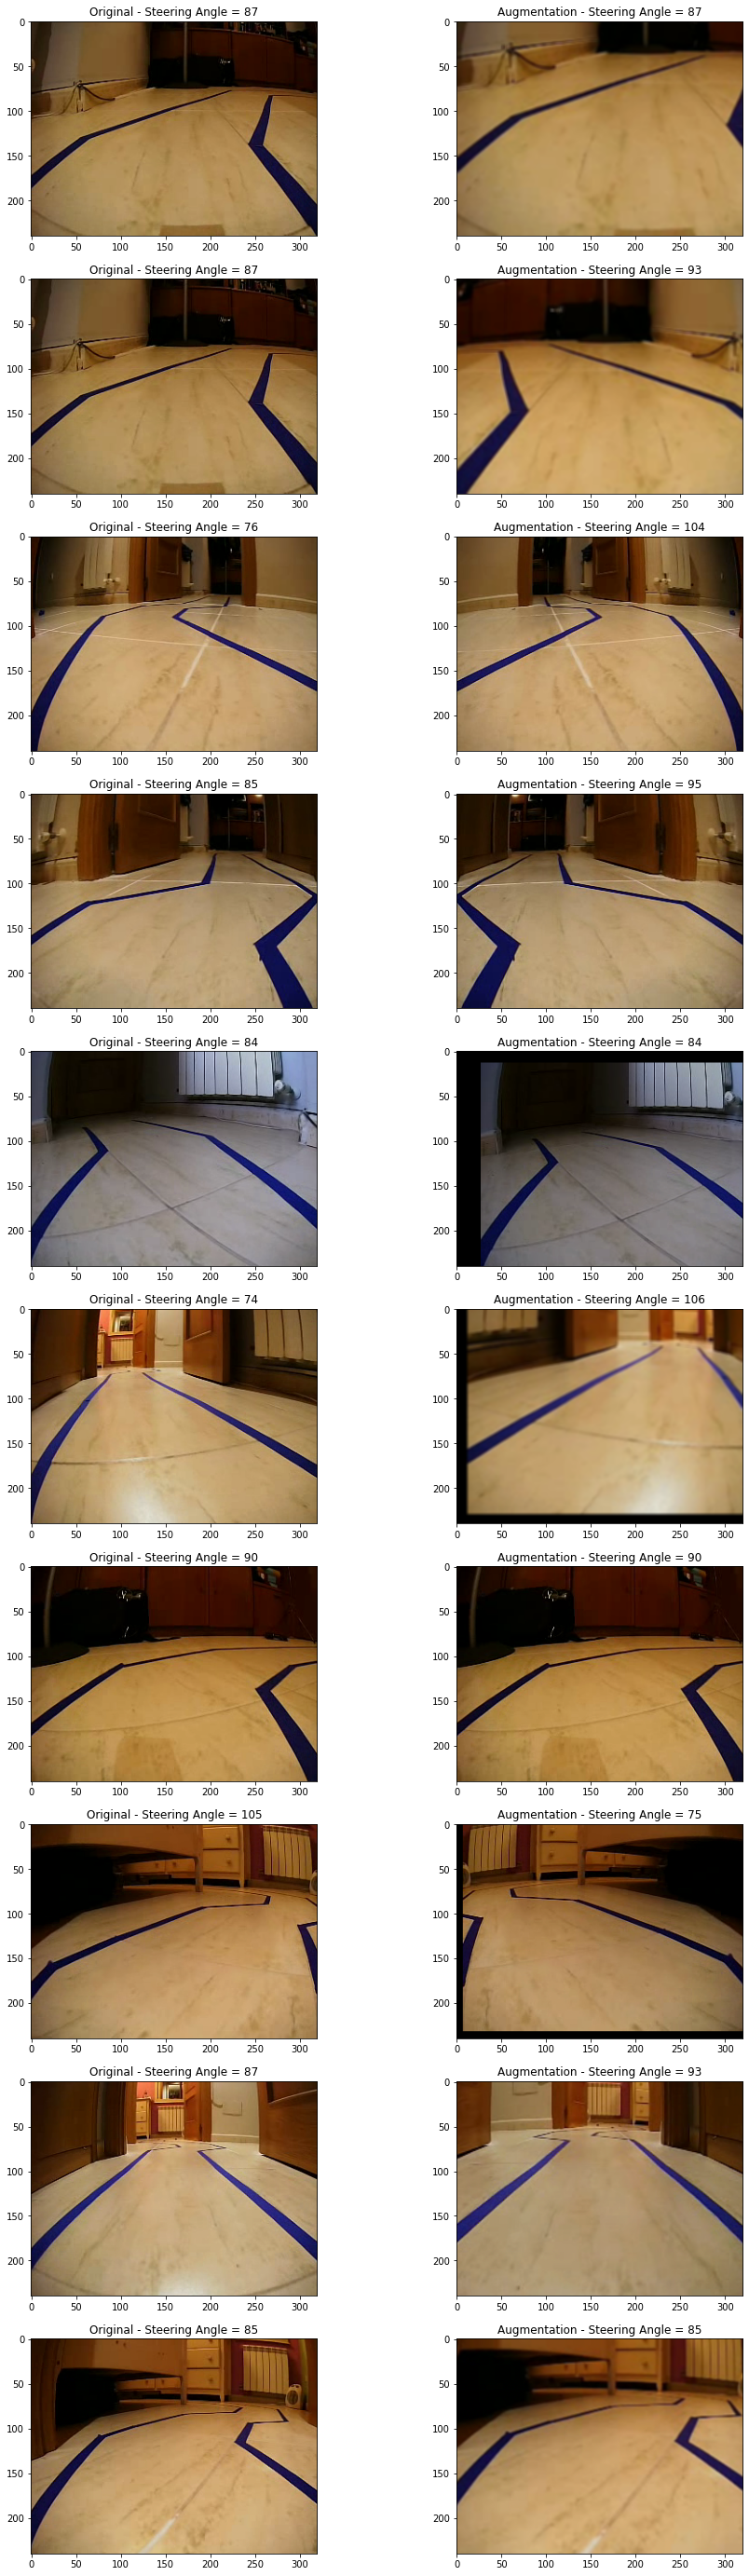

In [16]:
transformer = ImageTransformer()

num_columns = 2
num_rows = 10

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 50))

for i in range(num_rows):

    index = random.randint(0, len(X) - 1)
    original_angle = y[index]
    
    original_img = transformer.read_img(X[index])
    augmented_img, augmented_angle = transformer.randomly_augment_img(original_img, original_angle)

    axes[i][0].imshow(original_img)
    axes[i][0].set_title("Original - Steering Angle = %s" % original_angle)
    axes[i][1].imshow(augmented_img)
    axes[i][1].set_title("Augmentation - Steering Angle = %s" % augmented_angle)

## The CNN Model Architecture

I'll be constructing a CNN architecture inspired by Nvidia's End-to-End Deep Learning model for self-driving cars (https://developer.nvidia.com/blog/deep-learning-self-driving-cars/).


The architecture consists of 9 layers, which includes 1 normalization layer, 5 convolution layers, and 3 fully-connected layers. The model takes a 66x200 3-dimensional YUV colored input and outputs a steering angle (raw output). Our loss function will be the Mean Squared Error

**Architecture:**

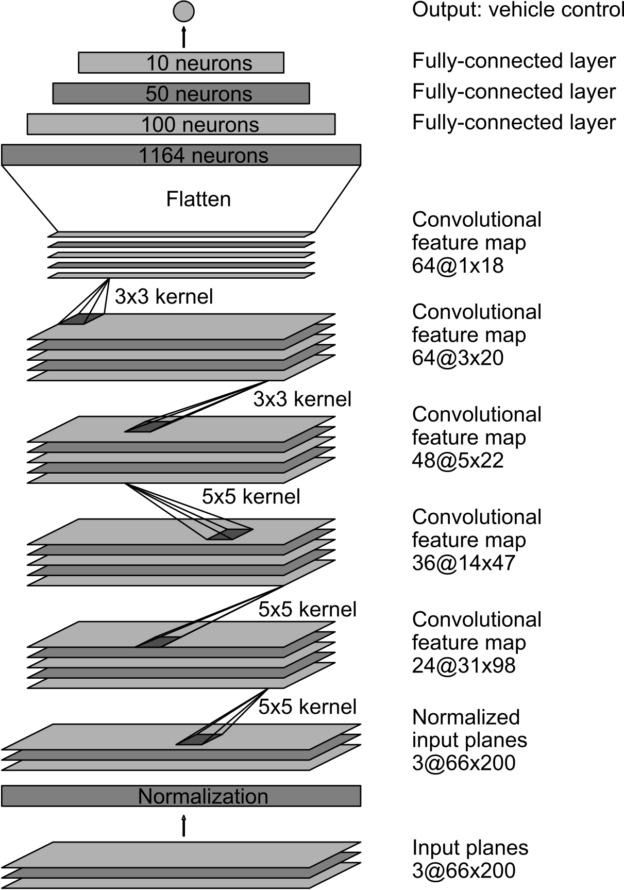



In [18]:
def cnn_model():

    model = Sequential(name="Nvidia_Self-Driving")

    # Input Layer
    model.add(Conv2D(filters=24, kernel_size=(5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))

    # Convolutional Layer
    model.add(Conv2D(filters=36, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(filters=48, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu'))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))

    # Output Layer
    model.add(Dense(1))

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer)

    return model

def preprocess_img(img):
    """
    Make images compatible with Nvidia Architecture
    """
            
    h, _, _ = img.shape
    # Crop top half of image 
    img = img[int(h/2):, :, :]  
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200, 66))
    # The Nvidia didn't rely on a normalization layer, rather they manually normalized each input
    img = img / 255 #RGB is from 0 to 255

    return img


**Test Preprocessing Transformations**


Text(0.5, 1.0, 'Transformed Image')

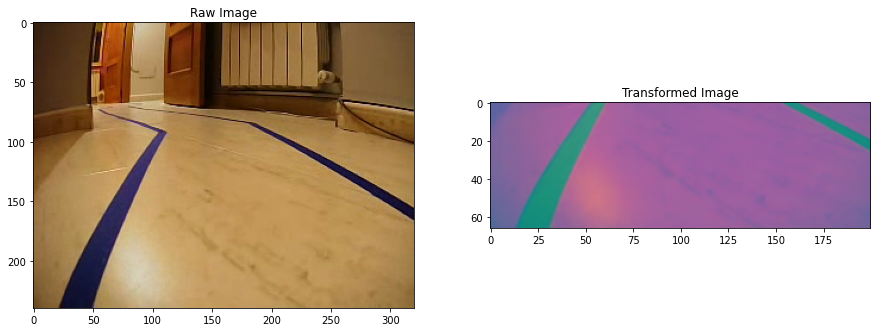

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15,10))
index = random.randint(0, len(X) - 1)
raw_img = transformer.read_img(X[index])
processed_img = preprocess_img(raw_img)
axes[0].imshow(raw_img)
axes[0].set_title("Raw Image")
axes[1].imshow(processed_img)
axes[1].set_title("Transformed Image")


In [44]:
model = cnn_model()
model.summary()

Model: "Nvidia_Self-Driving"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)       

**Build Generator Function**

In order to ensure I don't run out of RAM while performing data augmentation, I'll use fit_generator() and a generator function to construct my training batches

In [11]:
def generate_images(X, y, batch_size, perform_aug):
    """
    Generate training batches given batch size N. Batches comprise of 
    randomly selected images from training/valdination sets. If perform_aug=True,
    batches will also generate new images off of existing images (image augmentation) 
    """
    while True:

        batch_imgs = []
        batch_labels = []

        for i in range(batch_size):

            index = random.randint(0, len(X) - 1)
            img = transformer.read_img(X[index])
            steering_angle = y[index]

            # Perform Image Augmentation 
            if perform_aug:
                img, steering_angle = transformer.randomly_augment_img(img, steering_angle)
            # Prepare images for network
            img = preprocess_img(img)

            batch_imgs.append(img)
            batch_labels.append(steering_angle)

        yield(np.asarray(batch_imgs), np.asarray(batch_labels))


## Train Model

In [46]:
send_email("DL LKAS Training Has Begun")
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_directory, 'DL_LKAS_cp.h5'), verbose=1, save_best_only=True)
history = model.fit(
    generate_images(X_train, y_train, batch_size=100, perform_aug=True),
    steps_per_epoch=300,
    epochs=10,
    validation_data = generate_images(X_val, y_val, batch_size=100, perform_aug=True),
    validation_steps=200,
    verbose=1,
    shuffle=1,
    callbacks=[checkpoint_cb]
)
# Save Model Once Training Is Complete
model.save(os.path.join(output_directory, 'DL_LKAS_FINAL.h5'))

history_log_path = os.path.join(output_directory, 'history.pickle')
with open(history_log_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

send_email("DL LKAS Training Complete")



Epoch 1/10
300/300 [==============================] - 764s 3s/step - loss: 1190.7519 - val_loss: 126.6824

Epoch 00001: val_loss improved from inf to 126.68235, saving model to /content/drive/My Drive/Colab Notebooks/Data/Herbie/Saved Models/DL_LKAS_cp.h5
Epoch 2/10
300/300 [==============================] - 756s 3s/step - loss: 155.1941 - val_loss: 146.9588

Epoch 00002: val_loss did not improve from 126.68235
Epoch 3/10
300/300 [==============================] - 751s 3s/step - loss: 154.3653 - val_loss: 106.1790

Epoch 00003: val_loss improved from 126.68235 to 106.17904, saving model to /content/drive/My Drive/Colab Notebooks/Data/Herbie/Saved Models/DL_LKAS_cp.h5
Epoch 4/10
300/300 [==============================] - 760s 3s/step - loss: 100.0164 - val_loss: 49.9568

Epoch 00004: val_loss improved from 106.17904 to 49.95683, saving model to /content/drive/My Drive/Colab Notebooks/Data/Herbie/Saved Models/DL_LKAS_cp.h5
Epoch 5/10
300/300 [==============================] - 761s 3s/ste

## Evaluate Model

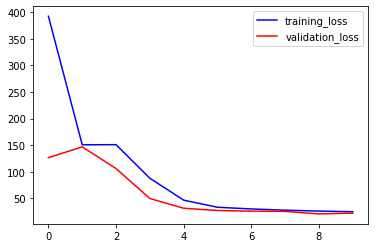

In [5]:


history_log_path = os.path.join(output_directory, 'history.pickle')
with open(history_log_path, 'rb') as f:
    history = pickle.load(f)

plt.plot(history['loss'], color='blue')
plt.plot(history['val_loss'], color='red')
plt.legend(["training_loss", "validation_loss"])

## Evalute On Test Set


In [6]:
from sklearn.metrics import mean_squared_error, r2_score

def prediction_stats(y_true, y_pred):

    mse = mean_squared_error(y_true, y_pred)
    r_squared = r2_score(y_true, y_pred)

    print(f'MSE     = {mse:.2}')
    print(f'R2      = {r_squared:.2%}')


def prediction_summary(X, y):
    
    model = load_model(f'{output_directory}/DL_LKAS_FINAL.h5')
    y_pred = model.predict(X)
    prediction_stats(y, y_pred)

    return y_pred

In [21]:
sample_size = 100

X_test_prep, y_test_prep = next(generate_images(X_test, y_test, sample_size, False))
y_pred = prediction_summary(X_test_prep, y_test_prep)

MSE     = 9.1
R2      = 91.26%
